In [ ]:
import os

# For JAX, we can use CPU (set SELECTED_DEVICE to empty (''), or one of the available GPUs)
SELECTED_DEVICE = 1
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'

In [1]:
import jax
import sys
jax.config.update("jax_default_device", jax.devices()[0])
jax.config.update("jax_enable_x64", True)

import jax.random as jrnd
import jax.numpy as jnp
import distrax as dx

print('Jax version:        ', jax.__version__)
print('Python version:     ', sys.version)
print('Jax default backend:', jax.default_backend())
print('Jax devices:        ', jax.devices())

from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

from typing import Callable
from jaxtyping import Float

from blackjax import rmh

import matplotlib.pyplot as plt

from jax.scipy.stats import gaussian_kde
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Set this to the directory of your clone of https://github.com/UncertaintyInComplexSystems/bayesianmodels
PATH_TO_UICSMODELS = '~/Documents/Repos/bayesianmodels'

import sys
sys.path.append(os.path.expanduser(PATH_TO_UICSMODELS))
from uicsmodels.bayesianmodels import BayesianModel, GibbsState

SMALL_SIZE = 12
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

def num_latent_vars(priors):
    """A little helper function to get the correct number of latent variables from a dictionary of distributions.
    """
    m = 0
    for _, dist in priors.items():
        m += jnp.prod(jnp.asarray(dist.batch_shape))
    return int(m)

#

Setting CUDA visible devices to [1]
Jax version:         0.4.6
Python version:      3.10.12 (main, Jul  5 2023, 18:54:27) [GCC 11.2.0]
Jax default backend: gpu
Jax devices:         [StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


The `UiCSmodels` repository is a lightweight wrapper around [Blackjax](https://blackjax-devs.github.io/blackjax/), the Jax Python library we use for Sequential Monte Carlo. The wrapper ensures that for shallow models, only a `loglikelihood_fn` needs to be defined, and for hierarchical models a `logprior_fn` as well.

Once these are available, inference can be called via `Bayesianmodel.inference()`. Different options are available for approximate inference, such as MCMC, but in particular SMC. SMC requires that the user provides:

- A log-likelihood function.
- A log-prior function.
- A proposal distribution for the mutations (Blackjax offers several; we default to Metropolis-Hastings MCMC).
- The parameters of the proposal distribution (such as stepsize).
- The number of mutation steps per SMC cycle.
- The number of particles to run.


# The mean of a Gaussian

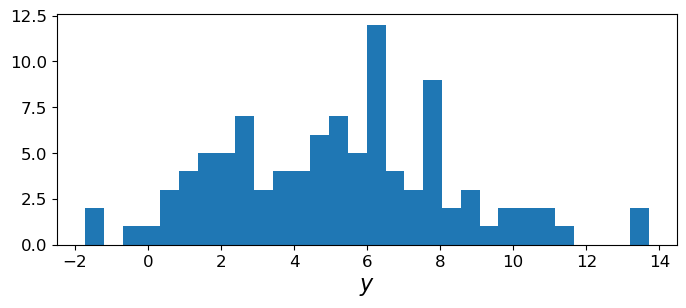

In [2]:
class GaussianUnknownMean(BayesianModel):

    def __init__(self, y, sd, priors):
        self.y = y
        self.sd = sd
        self.param_priors = priors

    #
    def loglikelihood_fn(self) -> Callable:
        """The define a function that returns the log-likelihood of a state. The state is essentially a dictionary with values assigned to all latent variables of the model.
        
        """

        def loglikelihood_fn_(state: GibbsState) -> Float:
            position = getattr(state, 'position', state)
            mu = position['mu']
            sd = self.sd
            return jnp.sum(dx.Normal(loc=mu, scale=sd).log_prob(self.y))
        
        #
        return loglikelihood_fn_
    
    #
    def exact_lml(self) -> Float:
        """For this simple model, the exact marginal likelihood is available (given a Gaussian prior on the mean), which allows us to compare the approximate SMC result with a ground truth.
        
        """
        assert self.param_priors['mu'] != dx.Normal, 'Exact marginal likelihood is only available for a Gaussian prior'                
        def gaussian_lml(y, sd, mu0, tau):
            # See https://www.cs.ubc.ca/~murphyk/Papers/bayesGauss.pdf
            y_bar = jnp.mean(y)
            n = len(self.y)
            return jnp.log(sd) - n/2*jnp.log(2*jnp.pi*sd**2) - 1/2*jnp.log(n*tau**2 + sd**2) - jnp.sum(y**2) / (2*sd**2) - mu0 / (2*tau**2) + (tau**2 * n**2 * y_bar**2 / sd**2 + sd**2*mu0**2 / tau**2 + 2*n*y_bar*mu0) / (2*(n*tau**2 + sd**2))
        
        #
        return gaussian_lml(self.y, self.sd, self.param_priors['mu'].loc, self.param_priors['mu'].scale)
    
    #
    def exact_posterior(self) -> dx.Distribution:
        """For this simple model, the exact posterior is available (given a Gaussian prior on the mean), which allows us to compare the approximate SMC result with a ground truth.
        
        """
        assert self.param_priors['mu'] != dx.Normal, 'Exact marginal likelihood is only available for a Gaussian prior'
        mu0 = self.param_priors['mu'].loc
        sd0 = self.param_priors['mu'].scale
        n = len(self.y)
        sd_post = 1.0 / (1/sd0**2 + n  / true_sd**2)
        mu_post = sd_post*(mu0 / sd0**2 + jnp.sum(y) / true_sd**2)

        return dx.Normal(loc=mu_post, scale=jnp.sqrt(sd_post))

    #

#

# Generate some data

key = jrnd.PRNGKey(5678)
key, key_data, key_inference = jrnd.split(key, 3)

true_mean = 5.0
true_sd = 3.0

n = 100

y = dx.Normal(loc=true_mean, scale=true_sd).sample(seed=key_data, sample_shape=(n, ))

plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.hist(y, bins=30)
ax.set_xlabel(r'$y$');


Our goal is to estimate the mean of a Gaussian distribution describing these observations. We are interested in the posterior $p(\mu \mid y_1, \ldots, y_n)$ as well as the marginal likelihood $p(y_1, \ldots, y_n)=\int p(y_1, \ldots, y_n \mid \mu) p(\mu) \,\text{d}\mu$.

In [3]:
mu0 = 0.0
sd0 = 2.0

# The prior on the mean
priors = dict(mu=dx.Normal(loc=mu0, scale=sd0))

# Instantiate the Bayesian model. We provide data, a ground truth standard deviation, and our prior on the latent variable.
gukmodel = GaussianUnknownMean(y, sd=true_sd, priors=priors)

# We now define all SMC settings. We have num_params parameters (only 1 here).
# We use the Metropolis-Hastings MCMC sampler for mutations (`rmh`), with a stepsize of 0.01
num_params = num_latent_vars(priors)
rmh_stepsize = 0.01
rmh_parameters = dict(sigma=rmh_stepsize*jnp.eye(num_params))

# We use 10_000 particles and 1_000 MCMC steps per SMC cycle.
num_mcmc = 1000
num_particles = 10_000

# The flag `include_trace` tells the algorithm to show the intermediate bridge distributions. In most applications, we do not care about these.
smc_parameters = dict(kernel=rmh,
                      kernel_parameters=rmh_parameters,
                      num_particles=num_particles,
                      num_mcmc_steps=num_mcmc,
                      include_trace=True)
# 
# Now commence SMC inference.
particles, num_adapt, lml, trace, temperature = gukmodel.inference(key_inference, mode='mcmc-in-smc', sampling_parameters=smc_parameters)

The adaptively-determined temperature is as follows:

(0.0, 1.0)

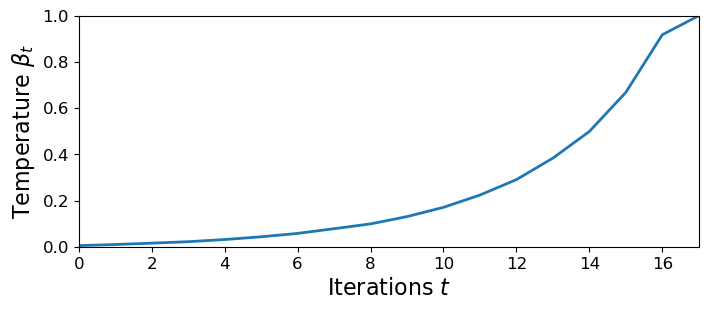

In [4]:
plt.figure(figsize=(8, 3))
ax = plt.gca()
ax.plot(jnp.arange(num_adapt), temperature, lw=2)
ax.set_xlabel(r'Iterations $t$')
ax.set_ylabel(r'Temperature $\beta_t$')
ax.set_xlim([0, num_adapt-1])
ax.set_ylim([0, 1]);

Now, we visualize the approximated distribution, the true distribution, as well as all intermediate distributions. As you can see, the algorithm slowly approximates the true posterior as the temperature is increased. At the end, the approximation and true distribution are nearly indistinguishable.

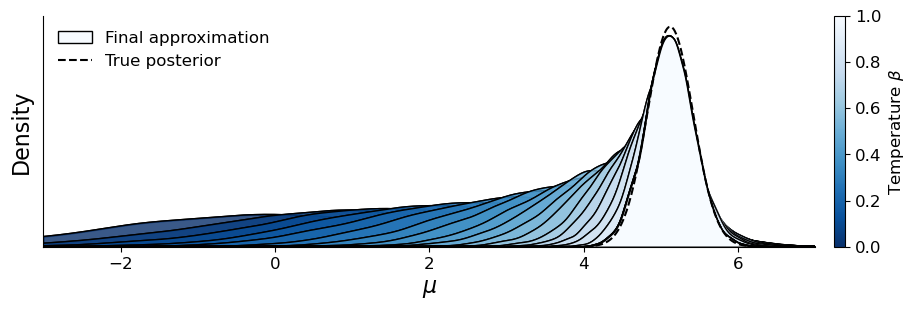

In [5]:
def plot_particles(ax, pdf, color, zorder=1.0, alpha=1.0, label=''):
    ax.plot(mu_range, pdf(mu_range), lw=1, color='k', zorder=zorder)
    ax.fill_between(mu_range, pdf(mu_range), jnp.zeros_like(mu_range), alpha=alpha, color=color, zorder=zorder, label=label)
    ax.plot(mu_range, pdf(mu_range), lw=1, color='k', zorder=zorder)

#
xlim = [-3, 7]
mu_range = jnp.linspace(*xlim, num=1000)

bridges = jnp.arange(num_adapt, step=1)
B = len(bridges)

cmap = plt.get_cmap('Blues_r')
norm = Normalize(vmin=0, vmax=1.0)

plt.figure(figsize=(12, 3))
ax = plt.gca()

for i, b in enumerate(bridges):    
    pdf = gaussian_kde(trace['mu'][b, :].flatten())
    plot_particles(ax, pdf, cmap(norm(i/B)), zorder=i, alpha=0.8)

pdf = gaussian_kde(particles.particles['mu'].flatten())
plot_particles(ax, pdf, cmap(norm(1.0)), zorder=999, label='Final approximation')

pdf_post = gukmodel.exact_posterior().prob(mu_range)
ax.plot(mu_range, pdf_post, ls='--', color='k', zorder=9999, label='True posterior')

ax.set_xlabel(r'$\mu$', fontsize=MEDIUM_SIZE)
ax.set_ylabel(r'Density', fontsize=MEDIUM_SIZE)
ax.set_ylim(bottom=0)
for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
ax.spines['bottom'].set_zorder(999999)
ax.set_xlim(*xlim)
ax.set_yticklabels([])
ax.set_yticks([])

handles, labels = ax.get_legend_handles_labels()
handles[0].set_edgecolor('k')
ax.legend(handles, labels, fontsize=SMALL_SIZE, frameon=False)

sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  
cbar = plt.colorbar(sm, ax=ax, pad=0.02)
cbar.set_label(r'Temperature $\beta$', fontsize=SMALL_SIZE)

filename = '/home/maxhin/Documents/Code/SMC tutorial/toy example/tempered_smc.pdf'
plt.savefig(filename, bbox_inches='tight', pad_inches=0.0)
plt.show()

The exact and approximated log marginal likelihoods are very close as well:

In [6]:
exact_lml = gukmodel.exact_lml()

print(f'Log marginal likelihood exact: {exact_lml:0.2f}')
print(f'Log marginal likelihood SMC estimate: {lml:0.2f}')

Log marginal likelihood exact: -261.16
Log marginal likelihood SMC estimate: -261.11
